In [4]:
import numpy as np

class LavenderGrowthEnv:
    def __init__(self):
        # state: [light, temp, humidity, photoperiod, EC, water_applied , number of water cycles ]
        self.state = np.array([5000, 25, 60, 16, 2.0, 0.5 , 3], dtype=np.float32)      # water in litre 

        self.M0 = 5
        self.M = self.M0
        self.conversion = 0.0185
        self.surface_area = 0.5  # m^2
        self.utilization_factor = 0.85
        self.absorption_factor = 0.9
        self.leaf_area = 0.3  # m^2
        self.LAI = self.leaf_area / self.surface_area
        self.max_days = 90
        self.day = 0

        self.light_range = (3000, 20000)
        self.temp_range = (15, 35)
        self.humidity_range = (30, 80)          
        self.photoperiod_range = (8, 24)         # hr 
        self.ec_range = (1.0, 3.0)            
        self.water_range = (0.1, 1.0)     # in litre (msh 3arfa )
        self.n_cycles_range = (1,5)

            # to start with 
        self.light_reset_range = (7000, 10000)   
        self.temp_reset_range = (25, 30)
        self.humidity_reset_range = (50, 60)
        self.photoperiod_reset_range = (14, 18)
        self.ec_reset_range = (1.8, 2.2)
        self.water_reset_range = (0.4, 0.6)
        self.n_cycles_reset_range = (1,3)


        self.action_steps = [-2, -1, 0, 1, 2]   # not for all 
        self.action_space = self._generate_actions()
        self.observation_space = len(self.state)

    def _generate_actions(self):
        # Now includes actions for light, temp, humidity, photoperiod, EC, water
        return [(l, t, h, p, e, w ,n)
                for l in self.action_steps # from actions  # light 
                for t in self.action_steps  # temp 
                for h in self.action_steps  # humidity 
                for p in [-1, 0, 1]   # phtoperiod (increase still decrease )
                for e in [-1, 0, 1]   # ec 
                for w in [-1, 0, 1]   # water applied (increase , still , decrease )
                for n in [-1,0,1]] 

    def step(self, action_index):
        action = self.action_space[action_index]
        for i in range(6):
            self.state[i] += action[i]

        # Clip state values to realistic ranges
        self.state[0] = np.clip(self.state[0], *self.light_range)
        self.state[1] = np.clip(self.state[1], *self.temp_range)
        self.state[2] = np.clip(self.state[2], *self.humidity_range)
        self.state[3] = np.clip(self.state[3], *self.photoperiod_range)
        self.state[4] = np.clip(self.state[4], *self.ec_range)
        self.state[5] = np.clip(self.state[5], *self.water_range)
        self.state[6] = np.clip(self.state[6] , *self.n_cycles_range)

        ppfd = self.state[0] * self.conversion      # lw hakhod el lux 
        T = self.state[1]
        RH = self.state[2]
        photoperiod = self.state[3]
        ec = self.state[4]
        w_applied = self.state[5]
        n_cycle = self.state[6]

        growth = self._plant_growth_rate(ppfd, T, RH, photoperiod, ec, w_applied ,4, n_cycle)

        self.M += growth
        self.day += 1

        done = self.day >= self.max_days
        reward = growth

        return np.array(self.state, dtype=np.float32), reward, done, {}

    def reset(self):
        # hakhod mn el reset values 
        self.state = np.array([
            np.random.randint(*self.light_reset_range),
            np.random.randint(*self.temp_reset_range),
            np.random.randint(*self.humidity_reset_range),
            np.random.randint(*self.photoperiod_reset_range),
            np.random.uniform(*self.ec_reset_range),
            np.random.uniform(*self.water_reset_range),
            np.random.uniform(*self.n_cycles_reset_range)
        ], dtype=np.float32)

        self.M = self.M0
        self.day = 0
        return np.array(self.state, dtype=np.float32)

    def _plant_growth_rate(self, ppfd, T, RH, photoperiod, ec, w_applied,ton, n_cycles):
        rue = 3
        dli = (ppfd * photoperiod * 3600) / 1_000_000
        dli_opt = 20
        sigma_dli = 5
        f_light = np.exp(-(dli - dli_opt) ** 2 / (2 * sigma_dli ** 2))
        par = ppfd * 0.0864 * self.absorption_factor

        temp_opt = 25
        sigma_temp = 5
        f_temp = np.exp(-(T - temp_opt) ** 2 / (2 * sigma_temp ** 2))

        ph = 6.0
        ph_opt = 6.0
        sigma_ph = 0.5
        f_ph = np.exp(-(ph - ph_opt) ** 2 / (2 * sigma_ph ** 2))

        ec_opt = 2.0
        sigma_ec = 0.5
        f_ec = np.exp(-(ec - ec_opt) ** 2 / (2 * sigma_ec ** 2))

        rh_opt = 60
        sigma_rh = 10
        f_rh = np.exp(-(RH - rh_opt) ** 2 / (2 * sigma_rh ** 2))

        # Water stress modeling
        VPD = (1 - RH / 100) * 0.611 * np.exp((17.27 * T) / (T + 237.3))
        w_apl = 0.5 * self.LAI * VPD
        alpha = 0.5
        gamma = 2
        f_water_base = 1 - (alpha * (abs(w_applied - w_apl) / w_apl) ** gamma)

        tdo = 2        #da 
        t_opt = 2
        sigma_T = 1
        c_cycle = np.exp(-((ton - t_opt) ** 2) / (sigma_T ** 2))

        # n_cycles = 3           # da       
        n_opt = 5
        sigma_cycles = 1
        f_n_cycles = 1 / (1 + ((n_cycles - n_opt) / sigma_cycles) ** 2)
        p_onoerobic = (((ton / tdo) - 1) ** sigma_T) * f_n_cycles

        f_water = f_water_base * c_cycle * (1 - p_onoerobic)

        growth = rue * f_light * par * f_temp * f_ph * f_ec * f_water * f_rh
        return max(growth, 0)


In [5]:
if __name__ == "__main__":
    env = LavenderGrowthEnv()

    print("Initial reset:")
    state = env.reset()
    print(f"State: {state}")
    print(f"Initial Biomass (M): {env.M}\n")

    for i in range(100):
        print(f"\n--- Step {i+1} ---")
        action_index = np.random.randint(len(env.action_space))  # Random action
        print(f"Action index: {action_index} -> Action: {env.action_space[action_index]}")
        
        new_state, reward, done, _ = env.step(action_index)
        
        print(f"New State: {new_state}")
        print(f"Growth (Reward): {reward:.4f}")
        print(f"Day: {env.day}")
        print(f"Biomass (M): {env.M:.4f}")
        print(f"Done: {done}")

        if done:
            break


Initial reset:
State: [9.6780000e+03 2.7000000e+01 5.0000000e+01 1.5000000e+01 1.9130880e+00
 4.4921422e-01 2.2860794e+00]
Initial Biomass (M): 5


--- Step 1 ---
Action index: 7732 -> Action: (1, 2, -2, 0, 0, -1, 0)
New State: [9.6790000e+03 2.9000000e+01 4.8000000e+01 1.5000000e+01 1.9130880e+00
 1.0000000e-01 2.2860794e+00]
Growth (Reward): 0.0180
Day: 1
Biomass (M): 5.0180
Done: False

--- Step 2 ---
Action index: 4812 -> Action: (0, -1, 2, 0, -1, 1, -1)
New State: [9.6790000e+03 2.8000000e+01 5.0000000e+01 1.5000000e+01 1.0000000e+00
 1.0000000e+00 2.2860794e+00]
Growth (Reward): 0.0039
Day: 2
Biomass (M): 5.0218
Done: False

--- Step 3 ---
Action index: 3100 -> Action: (-1, 0, 1, -1, 1, 0, 0)
New State: [9.6780000e+03 2.8000000e+01 5.1000000e+01 1.4000000e+01 2.0000000e+00
 1.0000000e+00 2.2860794e+00]
Growth (Reward): 0.0230
Day: 3
Biomass (M): 5.0448
Done: False

--- Step 4 ---
Action index: 8645 -> Action: (2, -1, -1, 1, -1, 0, 1)
New State: [9.6800000e+03 2.7000000e+01 5.0000

Training finished.


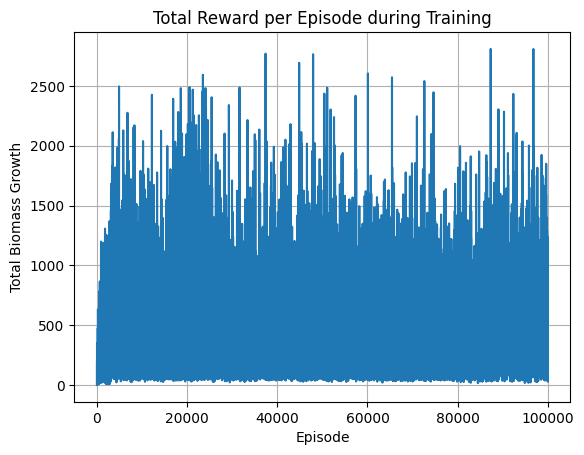

In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
# Q-learning setup
alpha = 0.1
gamma = 0.95
epsilon = 1.0
epsilon_decay = 0.999
min_epsilon = 0.05
num_episodes = 100000
max_steps = 90  # max number of days

def discretize_state(state):
    # Discretize state (light, temp, humidity) into bins
    light_bin = int((state[0] - env.light_range[0]) / (env.light_range[1] - env.light_range[0]) * 10)
    temp_bin = int((state[1] - env.temp_range[0]) / (env.temp_range[1] - env.temp_range[0]) * 10)
    humid_bin = int((state[2] - env.humidity_range[0]) / (env.humidity_range[1] - env.humidity_range[0]) * 10)

    light_bin = np.clip(light_bin, 0, 10)
    temp_bin = np.clip(temp_bin, 0, 10)
    humid_bin = np.clip(humid_bin, 0, 10)

    return (light_bin, temp_bin, humid_bin)

# Initialize environment and Q-table
env = LavenderGrowthEnv()
state_bins = (11, 11, 11)
num_actions = len(env.action_space)
q_table = np.zeros(state_bins + (num_actions,))

def choose_action(state_idx):
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, num_actions - 1)
    else:
        return np.argmax(q_table[state_idx])

# Training loop
episode_rewards = []
for episode in range(num_episodes):
    state = env.reset()
    state_idx = discretize_state(state)
    done = False
    episode_total_reward = 0

    for step in range(max_steps):
        action = choose_action(state_idx)
        next_state, reward, done, _ = env.step(action)
        next_state_idx = discretize_state(next_state)

        # Q-value update
        old_value = q_table[state_idx + (action,)]
        next_max = np.max(q_table[next_state_idx])
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)

        episode_total_reward += reward

        q_table[state_idx + (action,)] = new_value
        state_idx = next_state_idx

        if done:
            break
    episode_rewards.append(episode_total_reward)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

print("Training finished.")

# Plotting the rewards
plt.plot(episode_rewards)
plt.title("Total Reward per Episode during Training")
plt.xlabel("Episode")
plt.ylabel("Total Biomass Growth")
plt.grid(True)
plt.show()

In [18]:
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from gym import spaces
import matplotlib.pyplot as plt


class LavenderGrowthEnv:
    def __init__(self):
        self.state = np.array([5000, 25, 60, 16, 2.0, 0.5 , 3], dtype=np.float32)
        self.M0 = 5
        self.M = self.M0
        self.conversion = 0.0185
        self.surface_area = 0.1
        self.utilization_factor = 0.85
        self.absorption_factor = 0.9
        self.leaf_area = 0.3
        self.LAI = self.leaf_area / self.surface_area
        self.max_days = 100   # خليته 100 بدل 90
        self.day = 0

        self.light_range = (3000, 20000)
        self.temp_range = (15, 35)
        self.humidity_range = (30, 80)          
        self.photoperiod_range = (8, 24)      
        self.ec_range = (1.0, 3.0)            
        self.water_range = (0.1, 1.0)
        self.n_cycles_range = (1, 5)

        self.light_reset_range = (7000, 10000)   
        self.temp_reset_range = (25, 30)
        self.humidity_reset_range = (50, 60)
        self.photoperiod_reset_range = (14, 18)
        self.ec_reset_range = (1.8, 2.2)
        self.water_reset_range = (0.4, 0.6)
        self.n_cycles_reset_range = (1, 3)

        self.action_steps = [-2, -1, 0, 1, 2]
        # self.action_space = self._generate_actions()

        # تأكد من أن عدد الأفعال مناسب
        self.action_space = spaces.Discrete(100)  # على سبيل المثال 100 فعل فقط
        # self.observation_space = len(self.state)

    def _generate_actions(self):
        return [(l, t, h, p, e, w, n)
                for l in self.action_steps
                for t in self.action_steps
                for h in self.action_steps
                for p in [-1, 0, 1]
                for e in [-1, 0, 1]
                for w in [-1, 0, 1]
                for n in [-1, 0, 1]]

    def step(self, action_index):
        action = self.action_space[action_index]
        for i in range(6):
            self.state[i] += action[i]
        self.state[0] = np.clip(self.state[0], *self.light_range)
        self.state[1] = np.clip(self.state[1], *self.temp_range)
        self.state[2] = np.clip(self.state[2], *self.humidity_range)
        self.state[3] = np.clip(self.state[3], *self.photoperiod_range)
        self.state[4] = np.clip(self.state[4], *self.ec_range)
        self.state[5] = np.clip(self.state[5], *self.water_range)
        self.state[6] = np.clip(self.state[6], *self.n_cycles_range)

        ppfd = self.state[0] * self.conversion
        T = self.state[1]
        RH = self.state[2]
        photoperiod = self.state[3]
        ec = self.state[4]
        w_applied = self.state[5]
        n_cycle = self.state[6]

        growth = self._plant_growth_rate(ppfd, T, RH, photoperiod, ec, w_applied, n_cycle)

        self.M += growth
        self.day += 1

        done = self.day >= self.max_days
        reward = growth

        return np.array(self.state, dtype=np.float32), reward, done, {}

    def reset(self):
        self.state = np.array([
            np.random.randint(*self.light_reset_range),
            np.random.randint(*self.temp_reset_range),
            np.random.randint(*self.humidity_reset_range),
            np.random.randint(*self.photoperiod_reset_range),
            np.random.uniform(*self.ec_reset_range),
            np.random.uniform(*self.water_reset_range),
            np.random.uniform(*self.n_cycles_reset_range)
        ], dtype=np.float32)

        self.M = self.M0
        self.day = 0
        return np.array(self.state, dtype=np.float32)

    def _plant_growth_rate(self, ppfd, T, RH, photoperiod, ec, w_applied, n_cycles):
        rue = 3
        dli = (ppfd * photoperiod * 3600) / 1_000_000
        dli_opt = 20
        sigma_dli = 5
        f_light = np.exp(-(dli - dli_opt) ** 2 / (2 * sigma_dli ** 2))
        par = ppfd * 0.0864 * self.absorption_factor

        temp_opt = 25
        sigma_temp = 5
        f_temp = np.exp(-(T - temp_opt) ** 2 / (2 * sigma_temp ** 2))

        ph = 6.0
        ph_opt = 6.0
        sigma_ph = 0.5
        f_ph = np.exp(-(ph - ph_opt) ** 2 / (2 * sigma_ph ** 2))

        ec_opt = 2.0
        sigma_ec = 0.5
        f_ec = np.exp(-(ec - ec_opt) ** 2 / (2 * sigma_ec ** 2))

        rh_opt = 60
        sigma_rh = 10
        f_rh = np.exp(-(RH - rh_opt) ** 2 / (2 * sigma_rh ** 2))

        VPD = (1 - RH / 100) * 0.611 * np.exp((17.27 * T) / (T + 237.3))
        w_apl = 0.5 * self.LAI * VPD
        alpha = 0.5
        gamma = 2
        f_water_base = 1 - (alpha * (abs(w_applied - w_apl) / w_apl) ** gamma)

        ton = 2
        tdo = 5
        t_opt = 2
        sigma_T = 1
        c_cycle = np.exp(-((ton - t_opt) ** 2) / (sigma_T ** 2))

        n_opt = 3
        sigma_cycles = 1
        f_n_cycles = 1 / (1 + ((n_cycles - n_opt) / sigma_cycles) ** 2)
        p_onoerobic = ((ton / tdo) - 1) ** sigma_T * f_n_cycles

        f_water = f_water_base * c_cycle * (1 - p_onoerobic)

        growth = rue * f_light * par * f_temp * f_ph * f_ec * f_water * f_rh
        return max(growth, 0)

class LavenderGrowthEnvGym(gym.Env):
    def __init__(self):
        super(LavenderGrowthEnvGym, self).__init__()
        
        self.env = LavenderGrowthEnv()
        
        # مساحة الحالة: continuous (Box)
        self.observation_space = spaces.Box(
            low=np.array([
                self.env.light_range[0],
                self.env.temp_range[0],
                self.env.humidity_range[0],
                self.env.photoperiod_range[0],
                self.env.ec_range[0],
                self.env.water_range[0],
                self.env.n_cycles_range[0]
            ], dtype=np.float32),
            high=np.array([
                self.env.light_range[1],
                self.env.temp_range[1],
                self.env.humidity_range[1],
                self.env.photoperiod_range[1],
                self.env.ec_range[1],
                self.env.water_range[1],
                self.env.n_cycles_range[1]
            ], dtype=np.float32),
            dtype=np.float32
        )

        # مساحة الأفعال: Discrete
        self.action_space = spaces.Discrete(len(self.env.action_space))

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        state = self.env.reset()
        info = {}  # تقدر تضيف معلومات إضافية لو حبيت
        return state, info

    def step(self, action):
        next_state, reward, done, info = self.env.step(action)
        truncated = False  # غالباً ما تحتاجه، تحطه False
        return next_state, reward, done, truncated, info

    def render(self, mode='human'):
        pass

# نجهز البيئة
env = LavenderGrowthEnvGym()

# نتاكد أن البيئة سليمة
# check_env(env, warn=True)

# نجهز موديل PPO
model = PPO("MlpPolicy", env, verbose=1)

# نبدأ التدريب
model.learn(total_timesteps=100000)  # مثلا 100 ألف خطوة

# بعد التدريب نرسم المكافآت
rewards = []
episodes = 100

for episode in range(episodes):
    obs, _ = env.reset()  # تعديل هنا
    total_reward = 0
    done = False
    truncated = False
    while not (done or truncated):  # تعديل هنا
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)  # تعديل هنا
        total_reward += reward
    rewards.append(total_reward)


plt.plot(rewards)
plt.title("Total Reward per Episode during Testing")
plt.xlabel("Episode")
plt.ylabel("Total Biomass Growth")
plt.grid(True)
plt.show()


TypeError: object of type 'Discrete' has no len()